In [1]:
import os
import re
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import Axes3D

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.core.reference_space import ReferenceSpace

In [5]:
%matplotlib widget

Load Excel sheet to get metadata for experiment

### Load CCF info

I have been using the following resources to figure out how to use the AllenSDK to interact with the CCF:<br>
https://allensdk.readthedocs.io/en/latest/reference_space.html<br>https://allensdk.readthedocs.io/en/latest/connectivity.html<br>https://allensdk.readthedocs.io/en/latest/_static/examples/nb/mouse_connectivity.html<br>https://allensdk.readthedocs.io/en/latest/_static/examples/nb/reference_space.html#Downloading-an-annotation-volume

Also, this might be helpful when it comes to finding the reference coordinates:<br>https://community.brain-map.org/t/mouse-brain-reference-atlases-mapping-your-own-data/243

In [6]:
# The manifest file is a simple JSON file that keeps track of all of
# the data that has already been downloaded onto the hard drives.
# If you supply a relative path, it is assumed to be relative to your
# current working directory.
mcc = MouseConnectivityCache(resolution=25)
structure_tree = mcc.get_structure_tree()
mmpix = 0.025 # mm, we are using CCF with 25 um resolution for Tissuecyte
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

In [20]:
structure_tree.get_colormap()

{997: [255, 255, 255],
 8: [191, 218, 227],
 567: [176, 240, 255],
 688: [176, 255, 184],
 695: [112, 255, 112],
 315: [112, 255, 113],
 184: [38, 143, 69],
 68: [38, 143, 69],
 667: [38, 143, 69],
 526157192: [38, 143, 69],
 526157196: [38, 143, 69],
 526322264: [38, 143, 69],
 500: [31, 157, 90],
 107: [31, 157, 90],
 219: [31, 157, 90],
 299: [31, 157, 90],
 644: [31, 157, 90],
 947: [31, 157, 90],
 985: [31, 157, 90],
 320: [31, 157, 90],
 943: [31, 157, 90],
 648: [31, 157, 90],
 844: [31, 157, 90],
 882: [31, 157, 90],
 993: [31, 157, 90],
 656: [31, 157, 90],
 962: [31, 157, 90],
 767: [31, 157, 90],
 1021: [31, 157, 90],
 1085: [31, 157, 90],
 453: [24, 128, 100],
 12993: [24, 128, 100],
 12994: [24, 128, 100],
 12995: [24, 128, 100],
 12996: [24, 128, 100],
 12997: [24, 128, 100],
 12998: [24, 128, 100],
 322: [24, 128, 100],
 793: [24, 128, 100],
 346: [24, 128, 100],
 865: [24, 128, 100],
 921: [24, 128, 100],
 686: [24, 128, 100],
 719: [24, 128, 100],
 353: [24, 128, 100],

In [27]:
structure_tree.get_structures_by_acronym(['CL'])

[{'acronym': 'CL',
  'graph_id': 1,
  'graph_order': 700,
  'id': 575,
  'name': 'Central lateral nucleus of the thalamus',
  'structure_id_path': [997, 8, 343, 1129, 549, 856, 51, 575],
  'structure_set_ids': [112905828,
   691663206,
   687527945,
   688152363,
   12,
   184527634,
   167587189],
  'rgb_triplet': [255, 144, 159]}]

In [28]:
children = structure_tree[structure_tree['parent_structure_id']==575]['acronym'].values
print(children)

TypeError: 'StructureTree' object is not subscriptable

Used the following to create an annotation volume numpy array file for AIBSOPT->Tissuecyte code

# To look at single experiment

In [18]:
rec_folder = r'Q:\mouse771424\THstim_d1_2024-11-14_11-28-16\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [19]:
exp.data_folder

'Q:\\mouse771424\\THstim_d1_2024-11-14_11-28-16\\experiment1\\recording1'

In [20]:
with open(os.path.join(exp.data_folder, 'stim_elec_location.json')) as data_file:
    stimdata = json.load(data_file)

In [23]:
stimdata['tip']['area']

'TH'

In [24]:
tip_coords = np.array(stimdata['tip']['ccf_coords'])
print(tip_coords)

[243 144 169]


Text(0.5, 0.98, 'stim electrode')

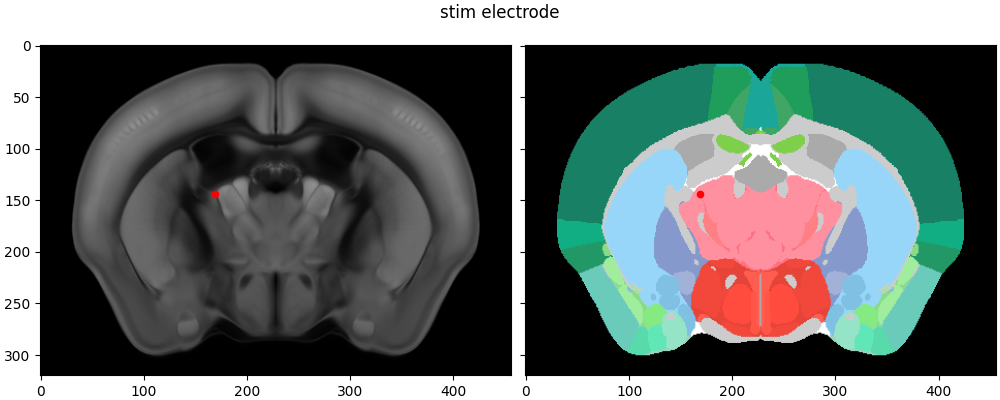

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True, sharex=True, sharey=True)

# tip, template #
axs[0].imshow(template[tip_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(tip_coords[2], tip_coords[1], s=20, c='r')

# tip, annot #
# axs[1].imshow(annot[tip_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_cmap = structure_tree.get_colormap()
ccf_cmap[0] = [0, 0, 0]
colim = np.reshape([ccf_cmap[point] for point in annot[tip_coords[0],:,:].flat], list(annot[tip_coords[0],:,:].shape) + [3]).astype(np.uint8)
axs[1].imshow(colim, aspect='equal')
axs[1].scatter(tip_coords[2], tip_coords[1], s=20, c='r')

plt.suptitle('stim electrode')

Try multiple experiments

In [24]:
sub_dirs = {
    '771424': [
        r'Q:\mouse771424\THstim_d1_2024-11-14_11-28-16\experiment1\recording1',
        r'Q:\mouse771424\THstim_d2_2024-11-15_10-51-49\experiment1\recording1'
    ],
    '771425': [
        r'P:\mouse771425\temp_sorted_TH_stim\mouse771425\THstim_d1_2024-11-21_10-59-24\experiment1\recording1',
        r'P:\mouse771425\temp_sorted_TH_stim\mouse771425\THstim_d2_2024-11-22_10-49-58\experiment1\recording1'
    ],
    # '771426': [
    #     r'R:\mouse771426\THstim_d1_2024-12-19_12-19-39\experiment1\recording1',
    #     r'R:\mouse771426\THstim_d2_2024-12-20_09-28-35\experiment1\recording1'
    # ],
}

ccf_cmap = structure_tree.get_colormap()
ccf_cmap[0] = [0, 0, 0]

Experiment type: electrical stimulation
771424: THstim_d1
[243 144 169]
Experiment type: electrical stimulation
771424: THstim_d2
[224 136 156]
Experiment type: electrical stimulation
771425: THstim_d1
[231 160 167]
Experiment type: electrical stimulation
771425: THstim_d2
[230 160 158]


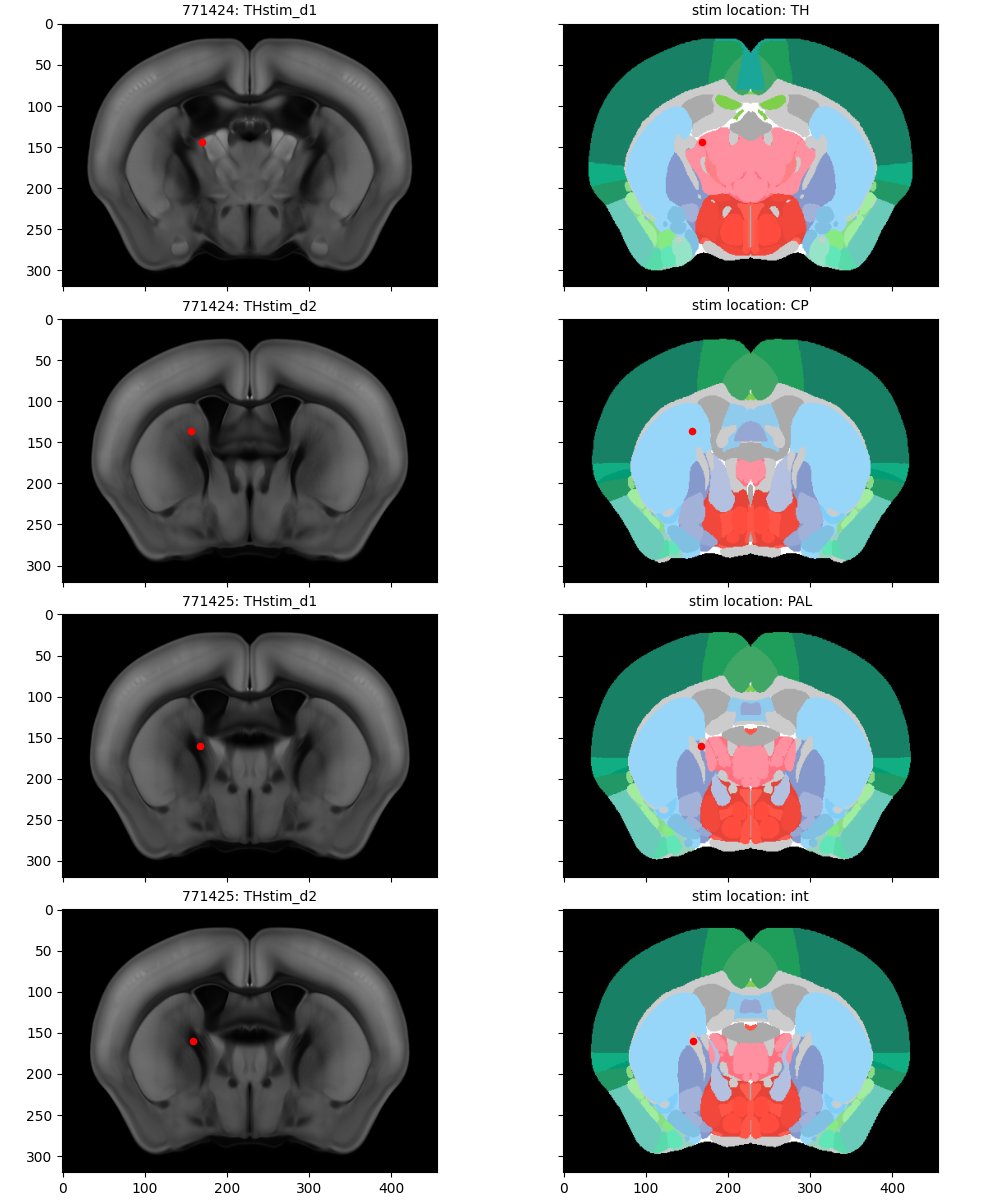

In [26]:
fig, axs = plt.subplots(4, 2, figsize=(10, 12), constrained_layout=True, sharex=True, sharey=True)
axi = 0
for mousei, dirlist in sub_dirs.items():
    for folderi in dirlist:
        expi = EEGexp(folderi, preprocess=False, make_stim_csv=False)
        exp_tag = expi.experiment_folder[expi.experiment_folder.find(str(expi.date.year))-10:expi.experiment_folder.find(str(expi.date.year))-1]
        with open(os.path.join(expi.data_folder, 'stim_elec_location.json')) as data_file:
            stimdata = json.load(data_file)
        tip_coords = np.array(stimdata['tip']['ccf_coords'])
        tip_area = stimdata['tip']['area']
        print('{}: {}'.format(mousei, exp_tag))
        print(tip_coords)

        ## Plot ##
        # tip, template #
        axs[axi,0].imshow(template[tip_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
        axs[axi,0].scatter(tip_coords[2], tip_coords[1], s=20, c='r')
        # tip, annot #
        colim = np.reshape([ccf_cmap[point] for point in annot[tip_coords[0],:,:].flat], list(annot[tip_coords[0],:,:].shape) + [3]).astype(np.uint8)
        axs[axi,1].imshow(colim, aspect='equal')
        axs[axi,1].scatter(tip_coords[2], tip_coords[1], s=20, c='r')
        
        axs[axi,0].set_title('{}: {}'.format(mousei, exp_tag))
        axs[axi,1].set_title('stim location: {}'.format(tip_area))

        axi += 1

In [10]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeA', 'probeD', 'probeE', 'probeF']


In [12]:
probe_info = {}
for probei in probe_list:
    probe_info[probei] = {}
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vert position of each ch (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels
    print('{} brain surface channel: {:d}'.format(probei, surface_ch))

    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
    all_ch_depths = allch_z[surface_ch] - allch_z
    
    probe_info[probei]['surface_channel'] = surface_ch
    probe_info[probei]['brain_chs'] = npx_chs
    probe_info[probei]['ch_depths'] = all_ch_depths
    if 'area_ch' in data.keys():
        probe_info[probei]['ch_areas'] = np.array(data['area_ch'])
        probe_info[probei]['ch_CCF_coords'] = np.array(data['ccf_coord_ch'])
        ## determine cortical chs ##
        ctx_mask = []
        for area in probe_info[probei]['ch_areas']:
            if area != 'null':
                ctx_mask.append(688 in structure_tree.get_structures_by_acronym([area])[0]['structure_id_path'])
            else:
                ctx_mask.append(False)
        probe_info[probei]['ctx_chs'] = npx_allch[ctx_mask]
    else:
        print('{} does not have area assignments.'.format(probei))

probeB brain surface channel: 354
probeC brain surface channel: 200
probeF brain surface channel: 360


Get stim electrode location from Zap_Zip-log_exp

In [13]:
exmetadata.head()

,mouse_name,exp_name,brain states,stimulation,visual_stim,audio_stim,ISI (sec),stimulus duration (msec),Current (uA),Cortical Area stimulation,N trials per stimulus,EEG bad_channels,Npx,Units Sorted (X),Brain slices (X),Brain areas assignment,"CCF coordinates stim electrode (surface,tip)","CCF area stim electrode (surface,tip)",Notes
1,mouse496220,audio_vis1_2020-06-10_14-54-43,awake/ISO,sensory,black/white,whitenoise/10000,5,250,,,60,None,None,None,None,None,None,None,None
2,mouse496220,audio_vis2_2020-06-11_11-42-47,awake/ISO,sensory,black/white,whitenoise/10000,5,250,,,60,29,None,None,None,None,None,None,None
3,mouse496220,audio_vis3_2020-06-16_10-35-57,run/resting,sensory,black,whitenoise,5,250,,,20,None,None,None,None,None,None,None,None
4,mouse496220,audio_vis4_2020-06-18_13-49-17,run/resting,sensory,black/white,whitenoise/10000,5,250,,,60,None,None,None,None,None,None,None,None
5,mouse521885,audio_vis1_2020-07-08_12-37-58,awake/ISO,sensory,black/white,whitenoise/10000,[3.5 4.5],250,,,50,6,None,None,None,None,None,None,None


In [14]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()

## Get electrode location from metadata ##
stim_elec_str = exp_meta['CCF coordinates stim electrode (surface,tip)']
# print(stim_elec_str)

stim_elec_coords = []
for char in stim_elec_str.split('],'):
    temp_coords = []
    for val in char.split(','):
        temp_coords.append(int(re.sub(r'\W+', '', val)))
    stim_elec_coords.append(np.array(temp_coords))
stim_elec_coords = np.array(stim_elec_coords)
print(stim_elec_coords)
print(stim_elec_coords.shape)

ValueError: invalid literal for int() with base 10: '25umresCCF'

In [15]:
## Stim electrode coordinates: ##
# stim_elec_coords = np.array([[454, 102, 433], [446, 178, 457]]) # 543396
# stim_elec_coords = np.array([[336, 136, 461], [429, 261, 497]]) # 546655
# stim_elec_coords = np.array([[390, 121, 439], [419, 267, 442]]) # 551400
# stim_elec_coords = np.array([[300, 166, 411], [300, 278, 441]]) # 551399
# stim_elec_coords = np.array([[372, 142, 395], [414, 266, 432]]) # 551397
# stim_elec_coords = np.array([[370, 146, 428], [428, 300, 434]]) # 569062
# stim_elec_coords = np.array([[293, 156, 456], [331, 266, 505]]) # 569069
# stim_elec_coords = np.array([[387, 125, 426], [467, 287, 502]]) # 551398
# stim_elec_coords = np.array([[273, 172, 431], [286, 314, 462]]) # 571619, estim2
# stim_elec_coords = np.array([[369, 134, 419], [415, 272, 461]]) # 569064
stim_elec_coords = np.array([[274, 16, 158], [287, 45, 169]]) # 586468

Plot electrode array map with probes and stim electrode

In [16]:
## Translate CCF coords to bregma coords, AP and ML ##
bregma = np.array([540, 0, 570]) # AP, DV, LR,
# from https://github.com/cortex-lab/allenCCF/blob/master/Browsing%20Functions/allenCCFbregma.m

probe_locs = {}
for probei in probe_list:
    probe_locs[probei] = {}
    probe_surface_CCF = probe_info[probei]['ch_CCF_coords'][probe_info[probei]['surface_channel']]
    probe_locs[probei]['AP'] = (bregma[0] - probe_surface_CCF[0]) * mmpix
    probe_locs[probei]['ML'] = (probe_surface_CCF[2] - bregma[2]) * mmpix
    
probe_locs['stim'] = {}
probe_locs['stim']['AP'] = (bregma[0] - stim_elec_coords[0,0]) * mmpix
probe_locs['stim']['ML'] = (stim_elec_coords[0,2] - bregma[2]) * mmpix

<IPython.core.display.Javascript object>


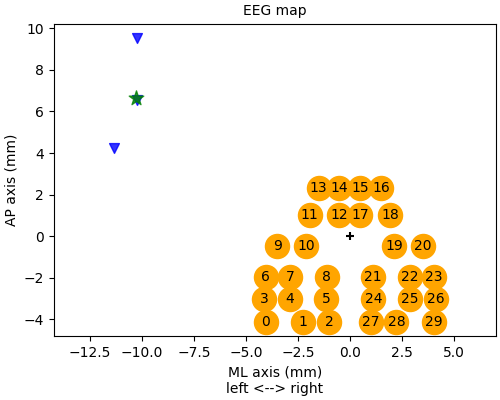

Text(0.5, 1.0, 'EEG map')

In [17]:
fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)

ax.scatter(EEGexp.EEG_channel_coordinates['ML'], EEGexp.EEG_channel_coordinates['AP'], s=300, color='orange')
ax.scatter(0, 0, marker='+', color='k')
ax.axis('equal')
    
for ind in range(len(EEGexp.EEG_channel_coordinates)):
    ax.annotate(
        str(ind),
        xy=(EEGexp.EEG_channel_coordinates['ML'].iloc[ind], EEGexp.EEG_channel_coordinates['AP'].iloc[ind]),
        ha='center', va='center', color='k'
    )
for thing, coords in probe_locs.items():
    if 'probe' in thing:
        tmarker = 'v'
        tcolor = 'b'
        tsize = 50
    else:
        tmarker = '*'
        tcolor = 'g'
        tsize = 120
    ax.scatter(coords['ML'], coords['AP'], marker=tmarker, color=tcolor, s=tsize, alpha=0.8)

ax.set_xlabel('ML axis (mm)\nleft <--> right')
ax.set_ylabel('AP axis (mm)')
ax.set_title('EEG map')# coordinates relative to bregma, need to figure out ML pos/neg convention

#### Plot probe surface and tip on template volume.

<IPython.core.display.Javascript object>


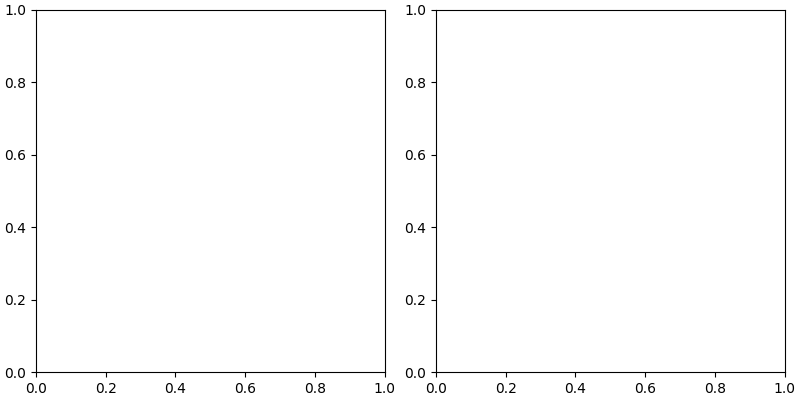

KeyError: 'stim'

In [18]:
plot_probe = 'stim'

fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
surface_coords = probe_info[plot_probe]['ch_CCF_coords'][probe_info[plot_probe]['surface_channel']]
axs[0].imshow(template[surface_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(surface_coords[2], surface_coords[1], s=20, c='r')
axs[0].set_title('surface: {}'.format(probe_info[plot_probe]['ch_areas'][probe_info[plot_probe]['surface_channel']]))

# tip #
tip_coords = probe_info[plot_probe]['ch_CCF_coords'][0]
axs[1].imshow(template[tip_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[1].scatter(tip_coords[2], tip_coords[1], s=20, c='r')
axs[1].set_title('tip: {}'.format(probe_info[plot_probe]['ch_areas'][0]))

plt.suptitle(plot_probe)

#### Plot stim electrode surface and tip

In [19]:
estim_surf_area = structure_tree.get_structures_by_id(
    [annot[stim_elec_coords[0,0],stim_elec_coords[0,1],stim_elec_coords[0,2]]])[0]['acronym']
estim_tip_area = structure_tree.get_structures_by_id(
    [annot[stim_elec_coords[1,0],stim_elec_coords[1,1],stim_elec_coords[1,2]]])[0]['acronym']

<IPython.core.display.Javascript object>


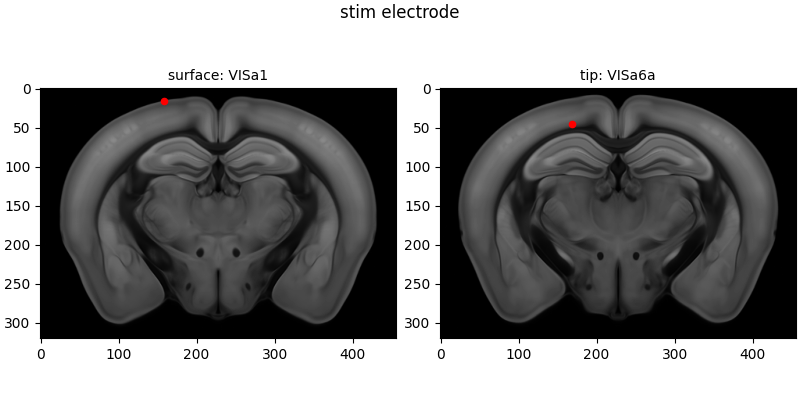

Text(0.5, 0.98, 'stim electrode')

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(template[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=20, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# tip #
axs[1].imshow(template[stim_elec_coords[1, 0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[1].scatter(stim_elec_coords[1, 2], stim_elec_coords[1, 1], s=20, c='r')
axs[1].set_title('tip: {}'.format(estim_tip_area))

plt.suptitle('stim electrode')

<IPython.core.display.Javascript object>


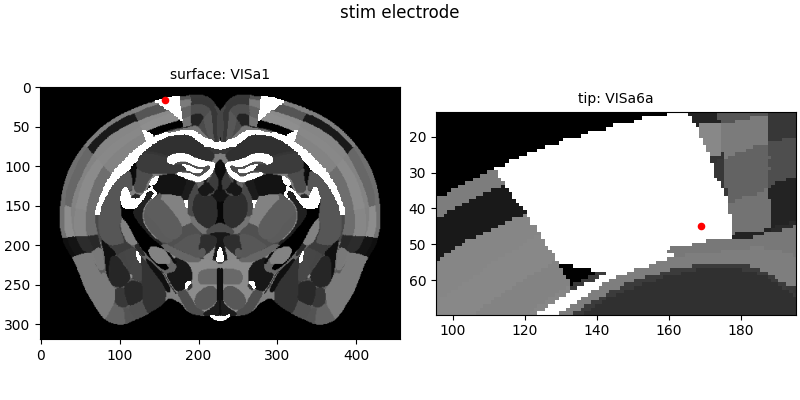

Text(0.5, 0.98, 'stim electrode')

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(annot[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=20, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# tip #
axs[1].imshow(annot[stim_elec_coords[1, 0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[1].scatter(stim_elec_coords[1, 2], stim_elec_coords[1, 1], s=20, c='r')
axs[1].set_title('tip: {}'.format(estim_tip_area))

plt.suptitle('stim electrode')

In [32]:
structure_tree.get_structures_by_id([9])[0]['acronym']

'SSp-tr6a'

In [15]:
len_stim_elec = np.linalg.norm(stim_elec_coords[0,:] - stim_elec_coords[1,:]) * mmpix
print('Length of stim electrode in brain: {:.2f} mm'.format(len_stim_elec)) # this is in mm now

Length of stim electrode in brain: 1.51 mm


In [16]:
print(stim_elec_coords[0,:])
print(stim_elec_coords[1,:])

[369 134 419]
[415 272 461]


Some linear algebra:

In [24]:
## get vector between the stim electrode surface and tip, points from surface to tip ##
stim_elec_vec = stim_elec_coords[1,:] - stim_elec_coords[0,:]
print(stim_elec_vec)

## get the norm and the direction vector ##
norm = np.linalg.norm(stim_elec_vec)
print(norm)
direction = stim_elec_vec / norm # unit vector
print(direction)

[13 29 11]
33.63034344160047
[0.38655567 0.8623165  0.32708557]


In [25]:
other_coords = (stim_elec_coords[1,:] - (0.3/mmpix) * direction).astype(int)
print(other_coords)
other_tip_area = structure_tree.get_structures_by_id(
    [annot[other_coords[0],other_coords[1],other_coords[2]]])[0]['acronym']

[282  34 165]


<IPython.core.display.Javascript object>


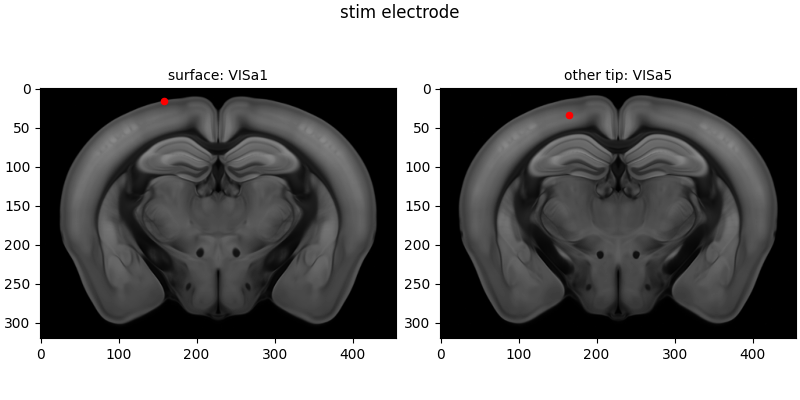

Text(0.5, 0.98, 'stim electrode')

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(template[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=20, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# other tip #
axs[1].imshow(template[other_coords[0],:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
axs[1].scatter(other_coords[2], other_coords[1], s=20, c='r')
axs[1].set_title('other tip: {}'.format(other_tip_area))

plt.suptitle('stim electrode')

In [27]:
len_stim_elec = np.linalg.norm(stim_elec_coords[0,:] - other_coords) * mmpix
print('Length of stim electrode in brain: {:.2f} mm'.format(len_stim_elec)) # this is in mm now

Length of stim electrode in brain: 0.52 mm


<IPython.core.display.Javascript object>


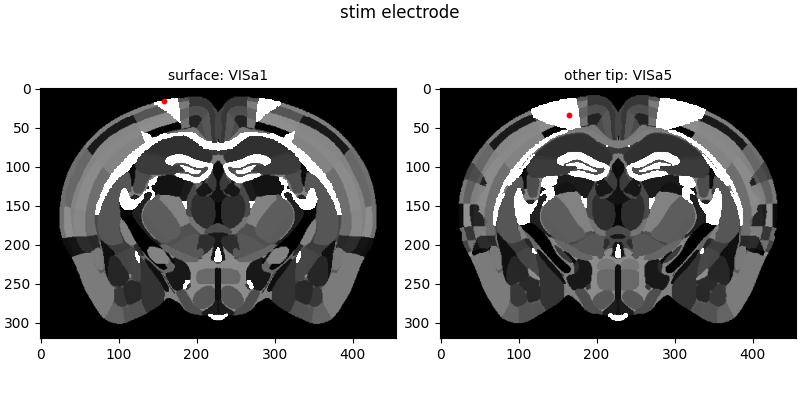

Text(0.5, 0.98, 'stim electrode')

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# surface #
axs[0].imshow(annot[stim_elec_coords[0, 0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[0].scatter(stim_elec_coords[0, 2], stim_elec_coords[0, 1], s=10, c='r')
axs[0].set_title('surface: {}'.format(estim_surf_area))

# other tip #
axs[1].imshow(annot[other_coords[0],:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
axs[1].scatter(other_coords[2], other_coords[1], s=10, c='r')
axs[1].set_title('other tip: {}'.format(other_tip_area))

plt.suptitle('stim electrode')

#### Need to reflect stim electrode from right to left hemi

In each of these multi-dimensional arrays, the 0th dimension refers to AP, the 1st dimension refers to DV, and the 2nd dimension refers to ML. In other words: (AP_dim, DV_dim, ML_dim).

# To look at multiple experiments

#### To print a list of areas for each probe

In [11]:
sub_dirs = {
    '590480a': r'T:\zap-n-zip\EEG_exp\mouse590480\estim_vis_2021-11-11_10-54-19\experiment1\recording1',
    '590480b': r'T:\zap-n-zip\EEG_exp\mouse590480\urethane_vis_2021-11-12_11-14-43\experiment1\recording1',
    '590481a': r'T:\zap-n-zip\EEG_exp\mouse590481\estim_vis_2021-11-18_10-52-12\experiment1\recording1',
    '590481b': r'T:\zap-n-zip\EEG_exp\mouse590481\urethane_vis_2021-11-19_10-59-04\experiment1\recording1',
    '599017a': r'T:\zap-n-zip\EEG_exp\mouse599017\estim_vis_2022-02-10_10-53-32\experiment1\recording1',
    '599017b': r'T:\zap-n-zip\EEG_exp\mouse599017\urethane_vis_2022-02-11_11-12-13\experiment1\recording1',
    '599975a': r'T:\zap-n-zip\EEG_exp\mouse599975\estim_vis_2022-03-31_12-03-06\experiment1\recording1',
    '599975b': r'T:\zap-n-zip\EEG_exp\mouse599975\urethane_vis_2022-04-01_10-58-41\experiment1\recording1',
    '618552a': r'T:\zap-n-zip\EEG_exp\mouse618552\estim_vis_2022-04-26_11-14-11\experiment1\recording1',
    '618552b': r'T:\zap-n-zip\EEG_exp\mouse618552\urethane_vis_2022-04-27_10-33-32\experiment1\recording1',
}
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation


In [12]:
for mousei, expi in sub_exp.items():
    exp_tag = expi.experiment_folder[expi.experiment_folder.find('mouse')+12:expi.experiment_folder.find(str(expi.date.year))-1]
    print('{} - {}'.format(mousei, exp_tag))
    
    ### Load unit data ###
    probe_list = [x.replace('_sorted', '') for x in expi.experiment_data if 'probe' in x]
    for probei in probe_list:
        ## Load probe_info.json ##
        with open(expi.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vertical position of each electrode (um), relative to the tip (ch 0 is 20 um from tip)
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels

        ## Get all brain ch areas ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
        if 'area_ch' in data.keys():
            ch_areas = np.array(data['area_ch'])[npx_chs]
            pr_area_list = np.unique(ch_areas)
            print(' {}: '.format(probei) + ', '.join(map(str, pr_area_list)))
        else:
            print('  NO area assignments.')
    print('')

590480a - estim_vis
 probeB: AV, CA1, CA2, CA3, LD, SSp-tr2/3, SSp-tr4, SSp-tr5, SSp-tr6a, SSp-tr6b, VAL, VISa1, VISa2/3, alv, ccb, cing, root
 probeC: DG-mo, DG-po, DG-sg, LP, PoT, ProS, SGN, VISp1, VISp2/3, VISp4, VISp5, VISp6a, VISp6b, alv, bsc, fiber tracts, fp, null, or
 probeF: ACAd5, ACAv1, DP, ILA1, LSr, MOs1, MOs2/3, MOs5, PL1, PL2/3, PL5, STR, TTd, null

590480b - urethane_vis
 probeB: CA1, CA2, CA3, LD, SSp-tr2/3, SSp-tr4, SSp-tr5, SSp-tr6a, SSp-tr6b, VAL, VISa1, VISa2/3, alv, ccb, cing, null, root
 probeF: ACAd5, ACAv1, DP, ILA1, ILA2/3, ILA5, LSr, MOs1, MOs2/3, MOs5, OLF, PL5, STR, TTd, root

590481a - estim_vis
 probeB: AD, AV, CA1, CA2, CA3, IAD, MOp6a, MOp6b, RSPagl1, RSPagl2/3, RSPagl5, RSPagl6a, alv, ccb, cing, null, root
 probeC: CA1, DG-mo, DG-po, DG-sg, LP, PoT, SGN, VISp1, VISp2/3, VISp4, VISp5, VISp6a, VISp6b, alv, bsc, fiber tracts, fp, null, or
 probeF: ACAd5, ACAv1, ACAv2/3, ACB, DP, ILA1, LSr, MOs1, MOs2/3, MOs5, PL1, PL2/3, PL5, STR, TTd, null

590481b - ure

#### To find average cortical chs across mice

In [7]:
sub_dirs = {
    '569069a': r'F:\EEG_exp\mouse569069\estim_vis1_2021-03-11_11-02-08\experiment1\recording1',
    '569069b': r'F:\EEG_exp\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
    '569072': r'F:\EEG_exp\mouse569072\estim_vis_2021-04-22_10-26-58\experiment1\recording1',
    '569073a': r'F:\EEG_exp\mouse569073\estim_vis_2021-04-15_10-27-22\experiment1\recording1',
    '569073b': r'F:\EEG_exp\mouse569073\estim_2021-04-16_10-42-44\experiment1\recording1',
    '571619a': r'F:\EEG_exp\mouse571619\estim1_2021-03-18_11-41-26\experiment1\recording1',
    '571619b': r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1',
#     '571618': r'F:\EEG_exp\mouse571618\estim1_2021-04-29_12-28-54\experiment1\recording1',
}

In [9]:
sub_ctx_chs = {}
for mousei, recdiri in sub_dirs.items():
    print(mousei)
    sub_ctx_chs[mousei] = {}
    expi = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
    probe_list = [x.replace('_sorted', '') for x in expi.experiment_data if 'probe' in x]
    
    for probei in probe_list:
        print(' {}'.format(probei))
        sub_ctx_chs[mousei][probei] = {}
        ## Load probe_info.json ##
        with open(expi.ephys_params[probei]['probe_info']) as data_file:
            data = json.load(data_file)
        npx_allch = np.array(data['channel']) # this is an array from 0 to 384
        surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
        allch_z = np.array(data['vertical_pos']) # vert pos of each electrode (um), rel to the tip (ch 0 is 20 um from tip)
        ref_mask = np.array(data['mask']) # contains a False for Npx reference channels

        ## Get all ch depths ##
        npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch]) 
        all_ch_depths = allch_z[surface_ch] - allch_z

        if 'area_ch' in data.keys():
            ch_areas = np.array(data['area_ch'])
            ## determine cortical chs ##
            ctx_chs = []
            for chi in npx_chs:
                if ch_areas[chi] != 'null':
                    if 315 in structure_tree.get_structures_by_acronym([ch_areas[chi]])[0]['structure_id_path']:
                        ctx_chs.append(chi)
            ctx_chs = np.array(ctx_chs)
            print('  surface channel: {:d}, {}'.format(surface_ch, ch_areas[surface_ch]))
            print('  {:d} cortical chs'.format(len(ctx_chs)))
            print('  last cortical channel: {:d}'.format(ctx_chs[0]))
            sub_ctx_chs[mousei][probei]['top'] = surface_ch
            sub_ctx_chs[mousei][probei]['bottom'] = ctx_chs[0]
        else:
            print('  .json file does not have area assignments.')
    print('')

569069a
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 probeB
  surface channel: 375, RSPd1
  92 cortical chs
  last cortical channel: 284
 probeC
  surface channel: 344, VISpm1
  81 cortical chs
  last cortical channel: 264
 probeF
  surface channel: 190, MOs1
  190 cortical chs
  last cortical channel: 0

569069b
Experiment type: electrical and sensory stimulation
 probeB
  surface channel: 350, RSPagl1
  107 cortical chs
  last cortical channel: 244
 probeC
  surface channel: 350, VISpm1
  103 cortical chs
  last cortical channel: 248
 probeF
  surface channel: 190, MOs1
  190 cortical chs
  last cortical channel: 0

569072
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 probeB
  surface channel: 360, SSp-tr1
  119 cortical chs
  last cortical channel: 242
 probeC
  surface channel: 365, VISrl1
  81 cortical chs
  last cortical channel: 284
 probeF
  surface channel: 265, null
  194 cortical chs
  last cortical

In [10]:
ctx_chs_df = pd.DataFrame(sub_ctx_chs)
ctx_chs_df.head()

,569069a,569069b,569072,569073a,569073b,571619a,571619b
probeB,"{'top': 375, 'bottom': 284}","{'top': 350, 'bottom': 244}","{'top': 360, 'bottom': 242}","{'top': 351, 'bottom': 244}","{'top': 351, 'bottom': 244}","{'top': 355, 'bottom': 289}","{'top': 340, 'bottom': 212}"
probeC,"{'top': 344, 'bottom': 264}","{'top': 350, 'bottom': 248}","{'top': 365, 'bottom': 284}","{'top': 360, 'bottom': 282}","{'top': 360, 'bottom': 282}","{'top': 350, 'bottom': 268}","{'top': 350, 'bottom': 268}"
probeF,"{'top': 190, 'bottom': 0}","{'top': 190, 'bottom': 0}","{'top': 265, 'bottom': 68}","{'top': 220, 'bottom': 28}","{'top': 210, 'bottom': 28}","{'top': 296, 'bottom': 54}","{'top': 285, 'bottom': 60}"


<IPython.core.display.Javascript object>


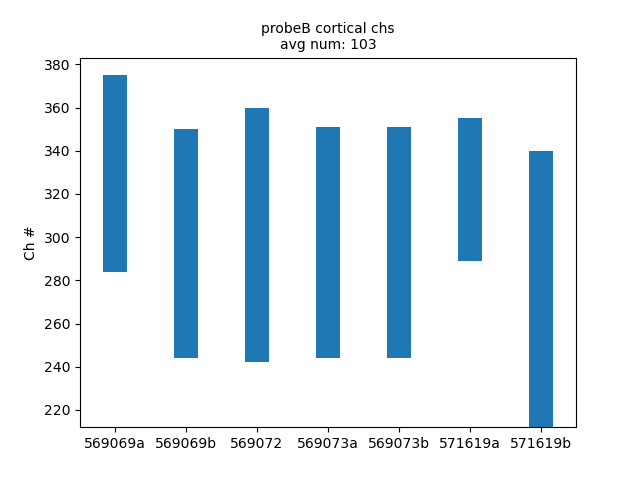

<IPython.core.display.Javascript object>


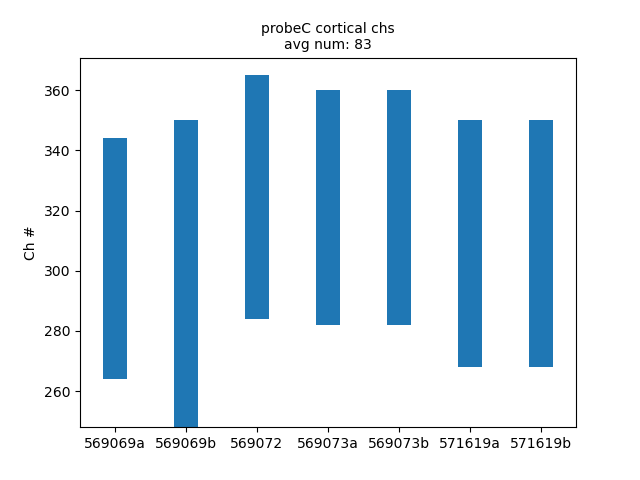

<IPython.core.display.Javascript object>


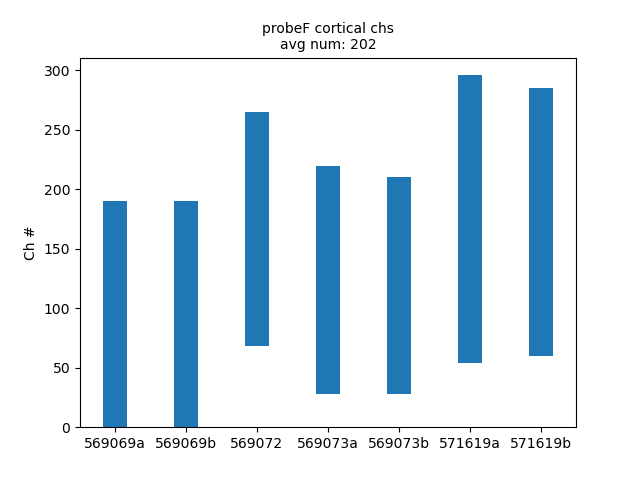

In [14]:
for pl_probe in probe_list:
    mice = []
    surf = []
    bot = []
    num_chs = []
    for mi in sub_ctx_chs.keys():
        mice.append(mi)
        surf.append(sub_ctx_chs[mi][pl_probe]['top'])
        bot.append(sub_ctx_chs[mi][pl_probe]['bottom'])
        num_chs.append(sub_ctx_chs[mi][pl_probe]['top']-sub_ctx_chs[mi][pl_probe]['bottom'])

    fig, ax = plt.subplots()
    ax.bar(mice, num_chs, 0.35, bottom=bot)
    ax.set_ylabel('Ch #')
    ax.set_title('{} cortical chs\navg num: {:d}'.format(pl_probe, int(np.mean(num_chs))))